In a previous [post](https://madhatter106.github.io/DataScienceCorner/posts/titanic-i-cleanup/), I took some initial steps in cleaning the [Titanic data set](https://www.kaggle.com/c/titanic). These included taking care of bad and missing data, one-hot encoding categorical data. I then did a first cull of the dataset to retain features I can feed to a classifier. While the resuting data set is essentially clean, it is not quite ready for classification. The remaining steps in the pre-processing chain are the topics of this post and can be broadly put under the umbrella term of dimension reduction. 
<!--TEASER_END-->

Reducing the number of features, if done properly has two potential benefits:
* computational efficiency
* increase in robustness by getting rid of relatively irrelevant and possibly noise-adding features.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np
%matplotlib inline

At the end of the previous [post](https://madhatter106.github.io/DataScienceCorner/posts/titanic-i-cleanup/) I pickled both training and test sets. I will reload them now.

In [2]:
dfTrain = pd.read_pickle('/home/madhatter106/DATA/Titanic/dfTrainCln_I.pkl')
dfTest = pd.read_pickle('/home/madhatter106/DATA/Titanic/dfTestCln_I.pkl')

Just as a reminder of where we left things off, here are the first two lines

In [3]:
dfTrain.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0


Here's a bit of feature engineering. The premise is that while people with children might have a greater chance at securing a spot on a raft, there could be a total number of family members beyond which chances of survival for any member might drop.

In [4]:
dfTrain['FamilySize'] = dfTrain['SibSp'] + dfTrain['Parch']
dfTest['FamilySize'] = dfTest['SibSp'] + dfTest['Parch']

In [5]:
dfTest.head(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0,0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0,1


In [57]:
features = ['Pclass','Age','SibSp','Parch','Fare','Sex_female','Sex_male','Embarked_C','Embarked_Q',
            'Embarked_S','FamilySize']
featIdx = {feat:i for i,feat in enumerate(features)}
X_train = dfTrain[features].values
y_train = dfTrain['Survived'].values
X_test = dfTest[features].values

Now I standardize the data. This is not strictly necessary when using decision trees or random forests, as I do below. However, I will be trying to have a few models compete in the [next post](), some of which require some kind of rescaling. 
Here, some of the data is binary so I standardize the continuous data using 2 standard deviation (*cf.* [Gelman] http://andrewgelman.com/2009/07/11/when_to_standar/ ) in order to bring these closer to the binary features.ca
I can't pass the whole data array however, since I dont' want the cardinal features to be standardize. I'll first specify the features to be standardized, extract the relevant data and pass these to the standard scaler.
That could be a possible improvement for sklearn standard scalign tool.

In [66]:
features_to_standardize = ['Age','SibSp','Parch','Fare','FamilySize']
std_col_idx = [features.index(feat) for feat in features_to_standardize]

Now I can standardize the relevant subset of both sets. Note that to do the standardization, I temporarily combine both training and testing features, to get a scale that applies to both uniformly. 
Also notice I divide the resulting rescaled data by 2, as that is equivalent to standardize by two standard deviations.

In [72]:
stc = StandardScaler()
stc.fit(np.vstack((X_train[:,std_col_idx], X_test[:,std_col_idx])))
X_train_std_sub = stc.transform(X_train[:, std_col_idx]) / 2
X_test_std_sub = stc.transform(X_test[:, std_col_idx]) / 2

Now to bring the standardize data alongside the cardinal features...

In [73]:
X_train_std = X_train
X_train_std[:, std_col_idx] = X_train_std_sub
X_test_std = X_test
X_test_std[:, std_col_idx] = X_test_std_sub

In [74]:
X_train_std.max(axis=0)

array([ 3.        ,  1.92138992,  3.60195475,  3.24478803,  4.63526731,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        2.8793187 ])

In [45]:
def std2stdev(X, Xall):
    """Assumes features are column-ordered"""
    return (X - Xall.mean(axis=0)) / (2 * Xall.std(axis=0))

In [46]:
X_train_2std = std2stdev(X_train, np.vstack((X_train, X_test)))
X_test_2std = std2stdev(X_test, np.vstack((X_train, X_test)))                          

In [51]:
X_train_std

array([[ 0.84191642, -0.56442088,  0.48128777, ..., -0.32204029,
         0.65501092,  0.07335229],
       [-1.54609786,  0.65135863,  0.48128777, ..., -0.32204029,
        -1.52669211,  0.07335229],
       [ 0.84191642, -0.260476  , -0.47908676, ..., -0.32204029,
         0.65501092, -0.55834605],
       ..., 
       [ 0.84191642, -0.56442088,  0.48128777, ..., -0.32204029,
         0.65501092,  1.33674898],
       [-1.54609786, -0.260476  , -0.47908676, ..., -0.32204029,
        -1.52669211, -0.55834605],
       [ 0.84191642,  0.19544132, -0.47908676, ...,  3.10520151,
        -1.52669211, -0.55834605]])

array([[ 0.42095821,  0.19270343, -0.23954338, -0.22249975, -0.25007092,
        -0.37174846,  0.37174846, -0.2548849 ,  1.55260076, -0.76334606,
        -0.27917303],
       [ 0.42095821,  0.6676173 ,  0.24064389, -0.22249975, -0.2581005 ,
         0.67249775, -0.67249775, -0.2548849 , -0.16102015,  0.32750546,
         0.03667615]])

I'm going to try a number of approaches to determine which features seem more important. These are,
1. random forest feature importance
2. sequential feature selection
3. linear discriminant analysis
4. principal component analysis

** Feature importance via random forest classifier **

In [9]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [30]:
def GetFeatureImportanceFromRFC(X, y, features):
    forest = RFC(n_estimators=10000,random_state=0,n_jobs=-1)
    forest.fit(X, y)
    imp = forest.feature_importances_
    sortIdx = np.argsort(imp)[::-1]
    totPerc = np.zeros(len(features))
    for i,idx in enumerate(sortIdx):
        print("%d - %s: %f" %(i+1,features[idx],imp[idx]))
        totPerc[i] = imp[idx]
    totPerc = totPerc.cumsum()
    f,ax = pl.subplots(figsize=(4+round(len(features)/3),6))
    ax.plot(totPerc)
    ax.stem(totPerc,linefmt='k:', markerfmt='ko')
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels([features[idx] for idx in sortIdx],rotation=60)
    print("forest score: %f" % forest.score(X, y));

1 - Age: 0.249118
2 - Fare: 0.245941
3 - Sex_male: 0.142407
4 - Sex_female: 0.141491
5 - Pclass: 0.080561
6 - FamilySize: 0.052883
7 - SibSp: 0.031339
8 - Parch: 0.023687
9 - Embarked_S: 0.013125
10 - Embarked_C: 0.012215
11 - Embarked_Q: 0.007234
forest score: 0.977553


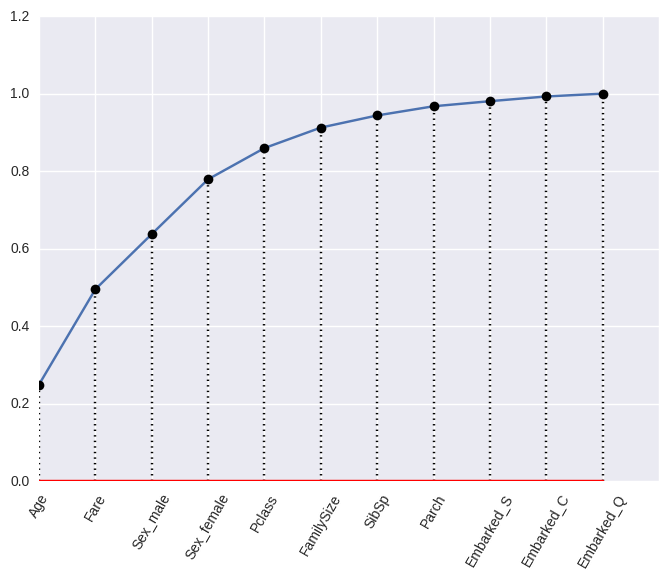

In [21]:
GetFeatureImportanceFromRFC(X_train_std, y_train, features)

The score gotten above is only an indicator to help in the feature selection. It should not be taken as an indicator of future performance on unseen data. In fact the score is so high, I would be surprised if overfitting was not an issue here. This will be addressed in a subsequent post. For the time being however, and  given the ranking of features returned by the random forest classifier, one might wonder whether, and to what degree, the classifier score might suffer if we removed some of the lower ranked features, and whether that would change the ranking of the remaining features.
There are a number of techniques that help with this kind on enquiry. One common approach is to use a sequential feature selector. This commonly comes in two main flavors, backward and forwardBeing pretty lazy, rather than coding it by hand I looked around to see if somebody 

In [32]:
# Sequential Selection. Here I am going to use Rabst's library add refs to Rabst's book and blog

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.naive_bayes import GaussianNB

Comment

In [38]:
gnb = GaussianNB()
efs1 = EFS(gnb, 
           min_features=1,
           max_features=10,
           scoring='accuracy',
           cv=5)
efs1 = efs1.fit(X_train_std[:,:-1], y_train)

Features: 1023/1023

In [41]:
efs1.get_metric_dict()

{0: {'avg_score': 0.67915672353975665,
  'ci_bound': 0.057280024622040779,
  'cv_scores': array([ 0.60335196,  0.67597765,  0.66853933,  0.71910112,  0.72881356]),
  'feature_idx': (0,),
  'std_dev': 0.044565805146646653,
  'std_err': 0.022282902573323327},
 1: {'avg_score': 0.62855612853027554,
  'ci_bound': 0.01949105622916621,
  'cv_scores': array([ 0.60335196,  0.62011173,  0.64606742,  0.63483146,  0.63841808]),
  'feature_idx': (1,),
  'std_dev': 0.01516470392153276,
  'std_err': 0.007582351960766379},
 2: {'avg_score': 0.52403007744911234,
  'ci_bound': 0.14313342511079463,
  'cv_scores': array([ 0.61452514,  0.61452514,  0.38764045,  0.38764045,  0.61581921]),
  'feature_idx': (2,),
  'std_dev': 0.11136266744908652,
  'std_err': 0.055681333724543251},
 3: {'avg_score': 0.6116705268873146,
  'ci_bound': 0.010514146932119136,
  'cv_scores': array([ 0.61452514,  0.61452514,  0.61797753,  0.59550562,  0.61581921]),
  'feature_idx': (3,),
  'std_dev': 0.008180363513316866,
  'std_er

In [42]:
print('Selected features:', [features[idx] for idx in efs1.best_idx_])

Selected features: ['Pclass', 'SibSp', 'Sex_female', 'Sex_male']


In [130]:
efs2 = EFS(gnb, min_features=1, max_features=11,scoring='accuracy', cv=5)
efs2 = efs2.fit(X_train_std, y_train)

Features: 2047/2047

I'm going to try all four flavors of sequential selectors; backward, backward floating, forward, forward floating.

In [ ]:
from sklearn.feature_selection import 

In [76]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [80]:
def CommonSelector(algo,fwdFlg,fltFlg,X,y):
    selector = SFS(algo, 
          k_features=11, 
          forward=fwdFlg, 
          floating=fltFlg, 
          scoring='accuracy',
          print_progress=False,
          cv=5,
          n_jobs=-1)
    selector = sfs.fit(X, y)
    return selector

In [85]:
from itertools import product 
SBtypflags  = product(['True','False'], repeat=2)
for fwdFlag, floatFlag in SBtypflags:
    gnb = GaussianNB()
    print('\nSequential  Selection, forward=%s, floating=%s' % (fwdFlag, floatFlag))
    selector = SFS(gnb,k_features=11, forward=fwdFlag, floating=floatFlag, scoring='accuracy',
                   print_progress=False, cv=5, n_jobs=-1)
    selector = selector.fit(X_train_norm, y_train)
    print('Selected features:', [features[idx] for idx in selector.k_feature_idx_])
    print('Indices: ', selector.k_feature_idx_)
    print('CV Score:')
    print(selector.k_score_)
    print(selector.)


Sequential  Selection, forward=True, floating=True


Features: 11/11

Selected features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize']
Indices:  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
CV Score:
0.790161419994

Sequential  Selection, forward=True, floating=False


Features: 11/11

Selected features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize']
Indices:  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
CV Score:
0.790161419994

Sequential  Selection, forward=False, floating=True


Features: 11/11

Selected features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize']
Indices:  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
CV Score:
0.790161419994

Sequential  Selection, forward=False, floating=False


Features: 11/11

Selected features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize']
Indices:  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
CV Score:
0.790161419994


In [98]:
selector.subsets_

{1: {'avg_score': 0.78671502492918788,
  'cv_scores': array([ 0.80446927,  0.80446927,  0.78651685,  0.75280899,  0.78531073]),
  'feature_idx': (5,)},
 2: {'avg_score': 0.79685905353844111,
  'cv_scores': array([ 0.80446927,  0.79888268,  0.78089888,  0.79213483,  0.8079096 ]),
  'feature_idx': (10, 5)},
 3: {'avg_score': 0.80360076842683514,
  'cv_scores': array([ 0.80446927,  0.81005587,  0.79213483,  0.79213483,  0.81920904]),
  'feature_idx': (10, 4, 5)},
 4: {'avg_score': 0.80473057007497384,
  'cv_scores': array([ 0.79329609,  0.81005587,  0.79775281,  0.80898876,  0.81355932]),
  'feature_idx': (10, 4, 5, 7)},
 5: {'avg_score': 0.80473057007497384,
  'cv_scores': array([ 0.79329609,  0.81005587,  0.79775281,  0.80898876,  0.81355932]),
  'feature_idx': (1, 10, 4, 5, 7)},
 6: {'avg_score': 0.80249600413080846,
  'cv_scores': array([ 0.7877095 ,  0.81005587,  0.79775281,  0.79775281,  0.81920904]),
  'feature_idx': (1, 3, 4, 5, 7, 10)},
 7: {'avg_score': 0.79915039682075284,
  'c

In [99]:
ft_idx = list(selector.subsets_[4]['feature_idx'])
list(features[idx] for idx in ft_idx)

['FamilySize', 'Fare', 'Sex_female', 'Embarked_C']

As predicted in the [previous post](https://madhatter106.github.io/DataScienceCorner/posts/titanic-i-cleanup/)

#### PCA



In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_std)